In [90]:
import numpy as np
import scipy
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua.utils.controlled_circuit import get_controlled_circuit
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-10-05 17:18:20,634: Credentials are already in use. The existing account in the session will be replaced.


# Some more imports  

In [113]:
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.aqua.algorithms import QPE
from qiskit.circuit.library import QFT
from qiskit.quantum_info import random_statevector
from qiskit.opflow import X,Y,Z,I,CX
pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

In [92]:
from qiskit.algorithms import NumPyEigensolver
from qiskit.aqua.operators import WeightedPauliOperator, MatrixOperator, op_converter

# Three Quantum Phase estimators are defined to compare on the same evolution matrix : 1st in-built QPE, 2nd my_qpe, 3rd QPE by DavidKach(Github)

# 2nd QPE : Defining matrix to control gate convertor, Quantum Phase Estimator and result.count to eigen value convertor

In [13]:
#Operator to gate convertor
def qc(operator):
    qubit_list = list(range(int(len(operator)/2)))
    qc = QuantumCircuit(len(qubit_list))
    qc.unitary(operator,qubit_list)
    qc = transpile(qc)
    #gate = qc.to_gate().control(1)
    return qc

In [14]:
#s_qubits is number available of energy levels
def evoloperator(s_qubits):
    evoloperator2 = QuantumCircuit(s_qubits)
    for p in range(s_qubits):
        for q in range(s_qubits):
            if (q > p):
                evoloperator2 = evoloperator2.compose(qc(operator),[p,q])
    evol_gate = evoloperator2#.to_gate().control(1)
    return evol_gate

In [99]:
# my_qpe takes in work qubits, simulation qubits, initialization condition and number of repetitions gate and applies QFT inverse
# Please convert/make sure the initial_state to a list before passing in argugement
def my_qpe(w_qubits,s_qubits, gate, initial_state = None, repetitions=1):  
    qpe_0 = QuantumCircuit(w_qubits+s_qubits,w_qubits)
    if (initial_state != None):
        qpe_0.initialize(initial_state,list(range(w_qubits,w_qubits+s_qubits)))
    for i in range(w_qubits):
        qpe_0.h(i)
    for counting_qubit in range(w_qubits):
        for j in range(trotter_number):
            for i in range(repetitions):
                qubit_list = [counting_qubit]+list(range(w_qubits,w_qubits+s_qubits))
                qpe_0.append(gate,qubit_list)
            repetitions *= 2
    qpe_1 = QFT(w_qubits, 0, True , True)
    l = [*range(w_qubits)]
    qpe = qpe_0.compose(qpe_1, l)
    qpe.measure(l,l)
    return qpe

In [66]:
#Eigen values of Hamiltonian operator H, n is to choose how many data points from the plot are we selecting
def plot_to_eigenval2(count,w_qubits,n):
    if t == 0:
        display(0)
    else:
        lists = sorted(count, key=count.get, reverse=True)[:n]
        #k=Counter(count).most_common(w_qubits) # Method to pick out the most probable outcomes based on number of expected eigen values
        for j in range(len(lists)):
            temp = str(lists[j])
            temp = temp[::-1]
            lists[j] =  int(temp, 2) #Convert them to decimal values
        for j in range(len(lists)):
            if (lists[j]>pow(2,w_qubits-1)):
                lists[j] = -2*pi*(lists[j])/((2**w_qubits)*t)
            else :
                lists[j] = 2*pi*lists[j]/((2**w_qubits)*t)
        return lists

# 3rd QPE

In [93]:
def exp_all_z(circuit, quantum_register, 
              pauli_idexes, control_qubit=None, t=1):
    """
    The implementation of exp(iZZ..Z t), where Z is 
    the Pauli Z operator, t is a parameter.
    :param circuit: QuantumCircuit.
    :param quantum_register: QuantumRegister.
    :param pauli_idexes: the indexes from quantum_register that 
                         correspond to entries not equal to I: 
                         e.g. if we have XIYZI then the 
                         pauli_idexes = [0,2,3].
    :param control_qubit: the control Qubit from QuantumRegister 
                          other than quantum_register.
    :param t: the parameter t in exp(iZZ..Z t).
    """
    # the controlled_exp(iIt) special case
    if len(pauli_idexes) == 0 and control_qubit is not None:
        circuit.add_register(control_qubit.register)
        circuit.u1(t, control_qubit)
        return
        
    # the first CNOTs
    for i in range(len(pauli_idexes) - 1):
        circuit.cx(quantum_register[pauli_idexes[i]],
                   quantum_register[pauli_idexes[i + 1]])
    
    # Rz gate
    if control_qubit is None:
        circuit.rz(-2 * t, quantum_register[pauli_idexes[-1]])
    else:
        circuit.add_register(control_qubit.register)
        circuit.crz(-2 * t, 
                    control_qubit, quantum_register[pauli_idexes[-1]])
    
    # the second CNOTs
    for i in reversed(range(len(pauli_idexes) - 1)):
        circuit.cx(quantum_register[pauli_idexes[i]],
                   quantum_register[pauli_idexes[i + 1]])

In [94]:
def exp_pauli(pauli, quantum_register, control_qubit=None, t=1):
    """
    The circuit for the exp(i P t), where P is the Pauli term, 
    t is the parameter.
    :param pauli: the string for the Pauli term: e.g. "XIXY".
    :param quantum_register: QuantumRegister.
    :param control_qubit: the control Qubit from QuantumRegister 
                          other than quantum_register.
    :param t: the parameter t in exp(i P t).
    :return: QuantumCircuit that implements exp(i P t) or 
             control version of it.
    """
    if len(pauli) != len(quantum_register):
        raise Exception("Pauli string doesn't match to the quantum register")

    pauli_circuit = QuantumCircuit(quantum_register)
    circuit_bracket = QuantumCircuit(quantum_register)
    pauli_idexes = []

    for i in range(len(quantum_register)):
        if pauli[i] == 'I':
            continue
        elif pauli[i] == 'Z':
            pauli_idexes.append(i)
        elif pauli[i] == 'X':
            circuit_bracket.h(quantum_register[i])
            pauli_idexes.append(i)
        elif pauli[i] == 'Y':
            circuit_bracket.u2(np.pi / 2, np.pi / 2, quantum_register[i])
            pauli_idexes.append(i)
    pauli_circuit += circuit_bracket
    exp_all_z(pauli_circuit, quantum_register, pauli_idexes, control_qubit, t)
    pauli_circuit += circuit_bracket

    return pauli_circuit

In [95]:
def hamiltonian_simulation(hamiltonian, quantum_register=None, 
                           control_qubit=None, t=1, trotter_number=1):
    """
    The implementation of exp(iHt), where H is the Hamiltonian 
    operator, t is the parameter.
    :param hamiltonian: dictionary of Pauli terms with their weights: 
                        e.g. {"XZX": 2, "ZYI": 5, "IYZ": 7}.
    :param quantum_register: QuantumRegister.
    :param control_qubit: the control Qubit from QuantumRegister 
                          other than quantum_register.
    :param t: the parameter t in exp(iHt).
    :param trotter_number: the Trotter number.
    :return: QuantumCircuit that corresponds to exp(iHt) 
             or control version of it.
    """
    if quantum_register is None:
        quantum_register = QuantumRegister(len(list(hamiltonian.keys())[0]))
    if control_qubit in quantum_register:
        raise Exception("the control qubit is in the target register")

    delta_t = t / trotter_number
    exp_hamiltonian = QuantumCircuit(quantum_register)
    exp_delta_t = QuantumCircuit(quantum_register)
    for pauli in hamiltonian:
        weight = hamiltonian[pauli]
        exp_delta_t += exp_pauli(pauli, quantum_register, 
                                 control_qubit, weight * delta_t)

    for i in range(trotter_number):
        exp_hamiltonian += exp_delta_t

    return exp_hamiltonian

In [96]:
simulator = Aer.get_backend('qasm_simulator')

## Test 1 : Ising Dimer Hamiltonian(Ref : "Optimizing quantum phase estimation for the simulation of Hamiltonian eigenstates")

In [106]:
#Same hamiltonian but defined differently for different algorithms
from qiskit.aqua.operators import WeightedPauliOperator
pauli_dict = {
        'paulis': [{"coeff": {"imag": 0.0, "real": 0.33}, "label": "ZI"},
                   {"coeff": {"imag": 0.0, "real": 3.24}, "label": "IZ"},
                   {"coeff": {"imag": 0.0, "real": 1.17}, "label": "ZZ"}
                   ]
}
hamiltonian1 = WeightedPauliOperator.from_dict(pauli_dict)
hamiltonian3 = {"ZI" : 0.33, "IZ" : 3.24, "ZZ" : 1.17}
H2_op = (0.33/trotter_number *  Z ^ I) + \
        (3.24/trotter_number * I ^ Z) + \
        (1.17/trotter_number * I ^ Z)
H2 = H2_op.exp_i()
hamiltonian2 = H2.to_matrix()

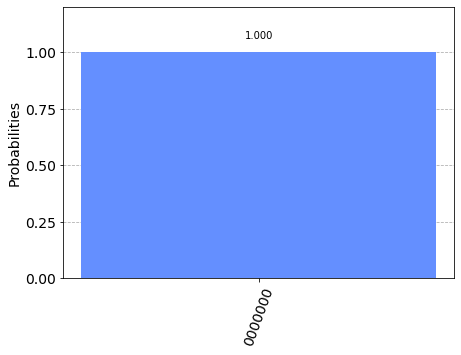

In [103]:
#QPE 1 : In-built QPE
initial_state = random_statevector(2**s_qubits).data
qft = QFT(num_qubits = 7,do_swaps =  True , inverse = True)
qpe = QPE(hamiltonian1,initial_state, qft,  num_time_slices=2, num_ancillae=7)
qpe1 = qpe.construct_circuit(measurement = True)
result = execute(qpe1, backend = simulator, shots = 3000).result()
count = result.get_counts(qpe1)
display(plot_histogram(count))

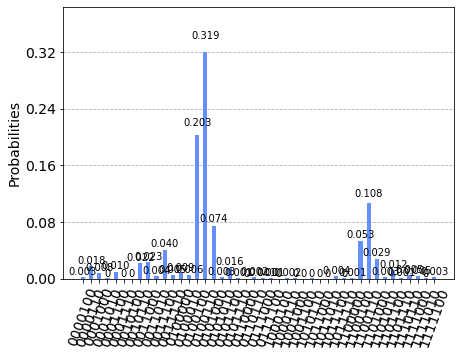

In [107]:
#QPE 2 : My QPE
w_qubits = 7
s_qubits = 2
trotter_number = 2
gate = qc(hamiltonian2).to_gate().control(1)
initial_state2 = [0,0,0,1]
qpe2 = my_qpe(w_qubits,s_qubits, gate, initial_state = initial_state2)
result = execute(qpe2, backend = simulator, shots = 3000).result()
count = result.get_counts(qpe2)
display(plot_histogram(count))

In [71]:
t = 
plot_to_eigenval2(count,w_qubits,2)

[0.803805932852076, -3.9453985864418692]

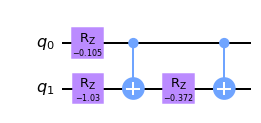

In [98]:
#QPE 3 : The QPE from Github

q = QuantumRegister(s_qubits, name="q")
a = QuantumRegister(w_qubits, name="a") 
c = ClassicalRegister(w_qubits, name="c") 

# Create a quantum circuit
circuit = QuantumCircuit(q, a, c)
circuit.initialize(initial_state,[q[0],q[1]])
circuit = hamiltonian_simulation(hamiltonian3, 
                                 q, t=1/(2*np.pi),trotter_number = 7)
display(circuit.draw())
#apply the controlled version of hamiltonian 
qpe3 = QuantumCircuit(a,c)
for ancillary in range(w_qubits):
    qpe3.h(ancillary)

for n in range(w_qubits):
    for m in range(2**n):
        get_controlled_circuit(circuit, a[n], qpe3)
# inverse QFT without SWAP gates
for n in reversed(range(a.size)):
    qpe3.h(a[n])
    if n != 0:
        for m in reversed(range(n)):
            angle = -2*np.pi / (2**(n - m + 1))
            qpe3.cu1(angle, a[n], a[m])

# measurements on the ancillary qubits stored in c classical register
for n in reversed(range(a.size)):
    qpe3.measure(a[n],c[n])
result = execute(qpe3, backend = simulator, shots = 3000).result()
count = result.get_counts(qpe3)
display(plot_histogram(count))